# Set up Data Retreival

In [23]:
# crs_text = "ESRI:102005"
crs_text = "EPSG:2263"
# crs_text = "EPSG:26918"

In [24]:
import geopandas as gpd
import urllib.request
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [43]:
# Retrieve Census Tiger Shapefile

# Set the download URL, file name and folder path
url = "https://www2.census.gov/geo/tiger/TIGER2019/BG/tl_2019_36_bg.zip"
filename = "tl_2019_36_bg.zip"
folder_path = "./data/ny_blockgroup_shapefile"

# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.mkdir(folder_path)

# Check if the shapefile exists, otherwise download and unzip it
if not os.path.exists(os.path.join(folder_path, "tl_2019_36_bg.shp")):
    # Download and unzip the shapefile
    urllib.request.urlretrieve(url, os.path.join(folder_path, filename))
    with zipfile.ZipFile(os.path.join(folder_path, filename), 'r') as zip_ref:
        zip_ref.extractall(folder_path)

# Read the shapefile into a geopandas GeoDataFrame
gdf = gpd.read_file(os.path.join(folder_path, "tl_2019_36_bg.shp"), crs=crs_text)

# '085' for Staten Island is removed for its lack of GTFS files
nyc_counties_fp = ['005', '047', '061', '081'] # FIPS codes for New York City counties
nyc_gdf = gdf[gdf['COUNTYFP'].isin(nyc_counties_fp)]
nyc_gdf = nyc_gdf.reset_index(drop=True)
nyc_gdf['GEOID'] = nyc_gdf['GEOID'].astype('int64')


In [44]:
# Retrieve Presaved networkx results

# Read the networkx_analysis.csv file into a pandas DataFrame
networkx_df = pd.read_csv("./data/networkx_analysis_results/networkx_analysis.csv")

# Convert the networkx_df DataFrame to a geopandas GeoDataFrame and create circles around each station
networkx_gdf = gpd.GeoDataFrame(
    networkx_df,
    geometry=gpd.points_from_xy(networkx_df.stop_lon, networkx_df.stop_lat),
    crs=crs_text
)

# Create a 1km buffer around the points in networkx_gdf
networkx_gdf_buffered = networkx_gdf.copy()

# Change the CRS to the desired CRS
networkx_gdf_buffered = networkx_gdf_buffered.to_crs(crs_text)
networkx_gdf_buffered.geometry = networkx_gdf_buffered.buffer(0.03)

# Convert the buffered points to a GeoDataFrame
networkx_gdf_buffered = gpd.GeoDataFrame(networkx_gdf_buffered)

In [45]:
# Retrieve Presaved Social Explorer NYC Blockgroup data results

sebg_df = pd.read_csv('./data/socialexplorer_nyc_blockgroup_data/socialexplorer_nyc_blockgroup_data.csv', header=1, delimiter=',')

In [46]:
# Join the two dataframes
nyc_gdf = pd.merge(sebg_df, nyc_gdf, left_on='Geo_FIPS', right_on='GEOID')

# Create Prelim Maps

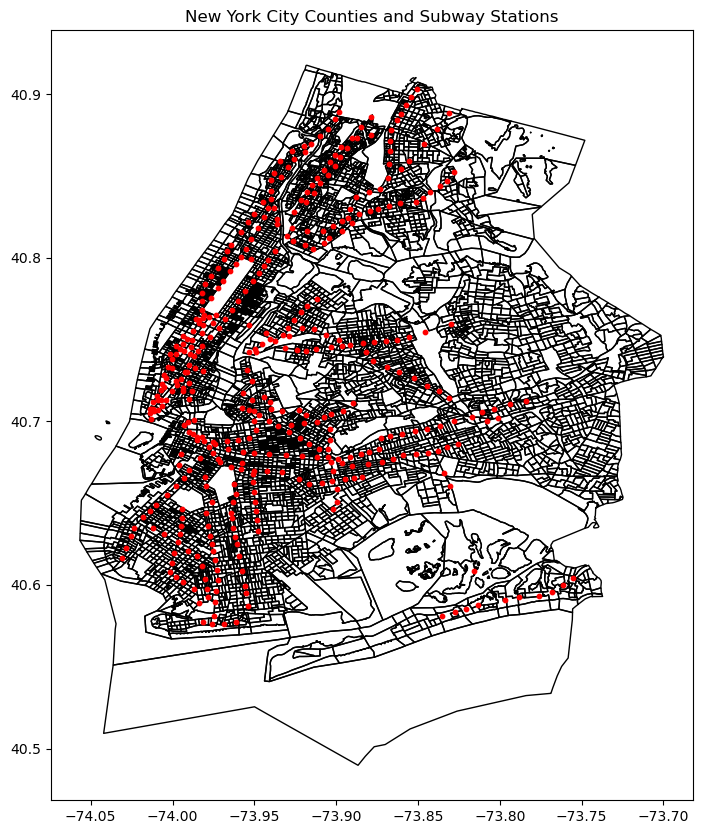

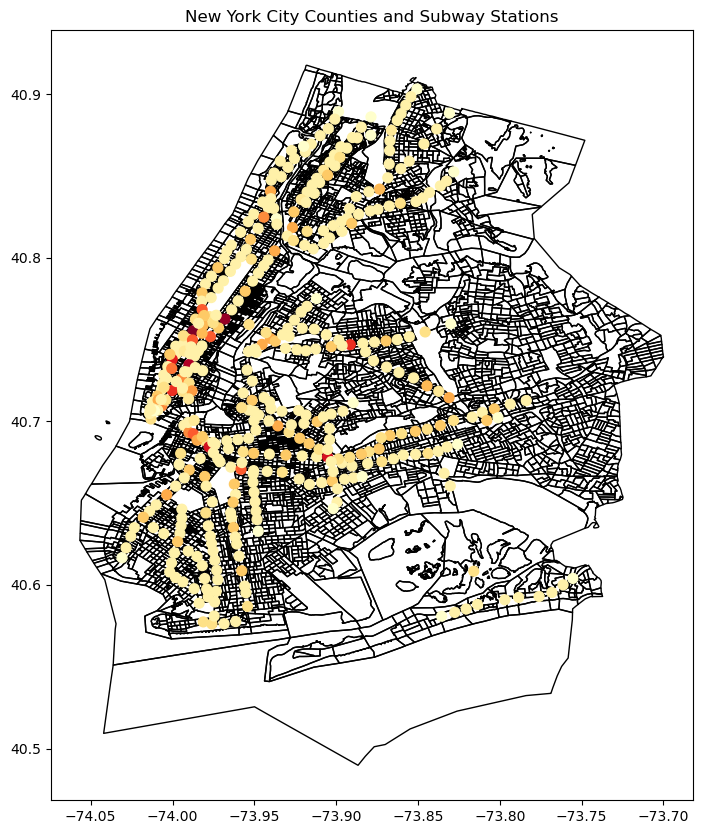

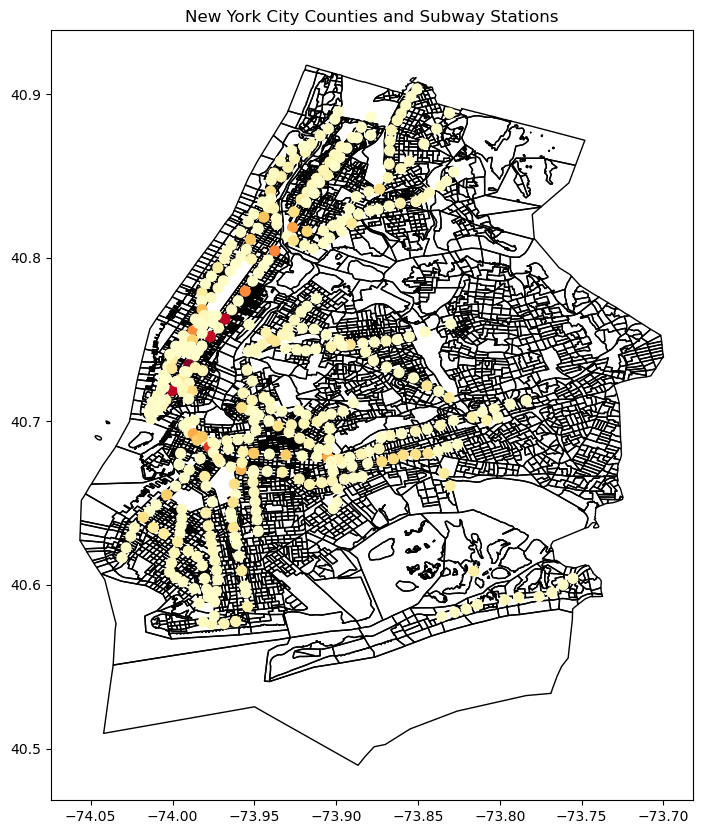

In [ ]:
# Create a map of New York City counties and overlay the station locations
fig, ax = plt.subplots(figsize=(10, 10))
nyc_gdf.plot(ax=ax, edgecolor='black', facecolor='none')
# networkx_gdf.plot(ax=ax, column='dgrs', cmap='YlOrRd', markersize=50)
networkx_gdf.plot(ax=ax, color='red', markersize=10)
ax.set_title('New York City Counties and Subway Stations')
plt.show()


# Create a map of New York City counties and overlay the station locations
fig, ax = plt.subplots(figsize=(10, 10))
nyc_gdf.plot(ax=ax, edgecolor='black', facecolor='none')
networkx_gdf.plot(ax=ax, column='dgrs', cmap='YlOrRd', markersize=50)
# stations_networkx_gdf.plot(ax=ax, color='red', markersize=10)
ax.set_title('New York City Counties and Subway Stations')
plt.show()


# Create a map of New York City counties and overlay the station locations
fig, ax = plt.subplots(figsize=(10, 10))
nyc_gdf.plot(ax=ax, edgecolor='black', facecolor='none')
networkx_gdf.plot(ax=ax, column='btwn', cmap='YlOrRd', markersize=50)
# stations_networkx_gdf.plot(ax=ax, color='red', markersize=10)
ax.set_title('New York City Counties and Subway Stations')
plt.show()

# Clean Data

In [ ]:
# TODO: Remove parks and/or water via a filter
# nyc_gdf WHERE ALAND is greater than 0 and B01001001 / SQRT(ALAND) > 0.023
nyc_gdf = nyc_gdf[(nyc_gdf['ALAND'] > 0) & (nyc_gdf['B01001001'] / nyc_gdf['ALAND'].apply(lambda x: pd.np.sqrt(x)) > 0.023)]

KeyError: 'B01001001'

In [ ]:
nyc_gdf

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
3,36,081,025900,2,360810259002,Block Group 2,G5030,S,64620,0,+40.7464004,-073.9045386,"POLYGON ((-73.90642 40.74564, -73.90535 40.747..."
4,36,081,016600,2,360810166002,Block Group 2,G5030,S,91377,0,+40.6783653,-073.8192669,"POLYGON ((-73.82136 40.68050, -73.82044 40.680..."
5,36,081,122702,1,360811227021,Block Group 1,G5030,S,72543,0,+40.7312033,-073.8128367,"POLYGON ((-73.81502 40.73047, -73.81492 40.732..."
6,36,081,028300,5,360810283005,Block Group 5,G5030,S,36881,0,+40.7495638,-073.8856985,"POLYGON ((-73.88654 40.75159, -73.88561 40.751..."
7,36,081,148300,4,360811483004,Block Group 4,G5030,S,286390,0,+40.7732667,-073.7501807,"POLYGON ((-73.75557 40.77153, -73.75550 40.771..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15434,36,005,022401,1,360050224011,Block Group 1,G5030,S,35632,0,+40.8561564,-073.8688238,"POLYGON ((-73.86993 40.85586, -73.86989 40.855..."
15440,36,005,038900,1,360050389001,Block Group 1,G5030,S,48230,0,+40.8565967,-073.8836054,"POLYGON ((-73.88543 40.85576, -73.88465 40.856..."
15441,36,005,007100,2,360050071002,Block Group 2,G5030,S,210622,0,+40.8174963,-073.9134556,"POLYGON ((-73.91763 40.81605, -73.91676 40.816..."
15442,36,005,021100,3,360050211003,Block Group 3,G5030,S,42251,0,+40.8391029,-073.9244240,"POLYGON ((-73.92578 40.83923, -73.92527 40.840..."


# Join Data

c:\Users\cjong\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\cjong\AppData\Local\Temp\ipykernel_5312\1220408551.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4269
Right CRS: EPSG:2263

  joined_gdf = gpd.sjoin(nyc_gdf, networkx_gdf_buffered, how='inner', op='intersects').groupby(['GEOID'])[['btwn']].mean().reset_index()


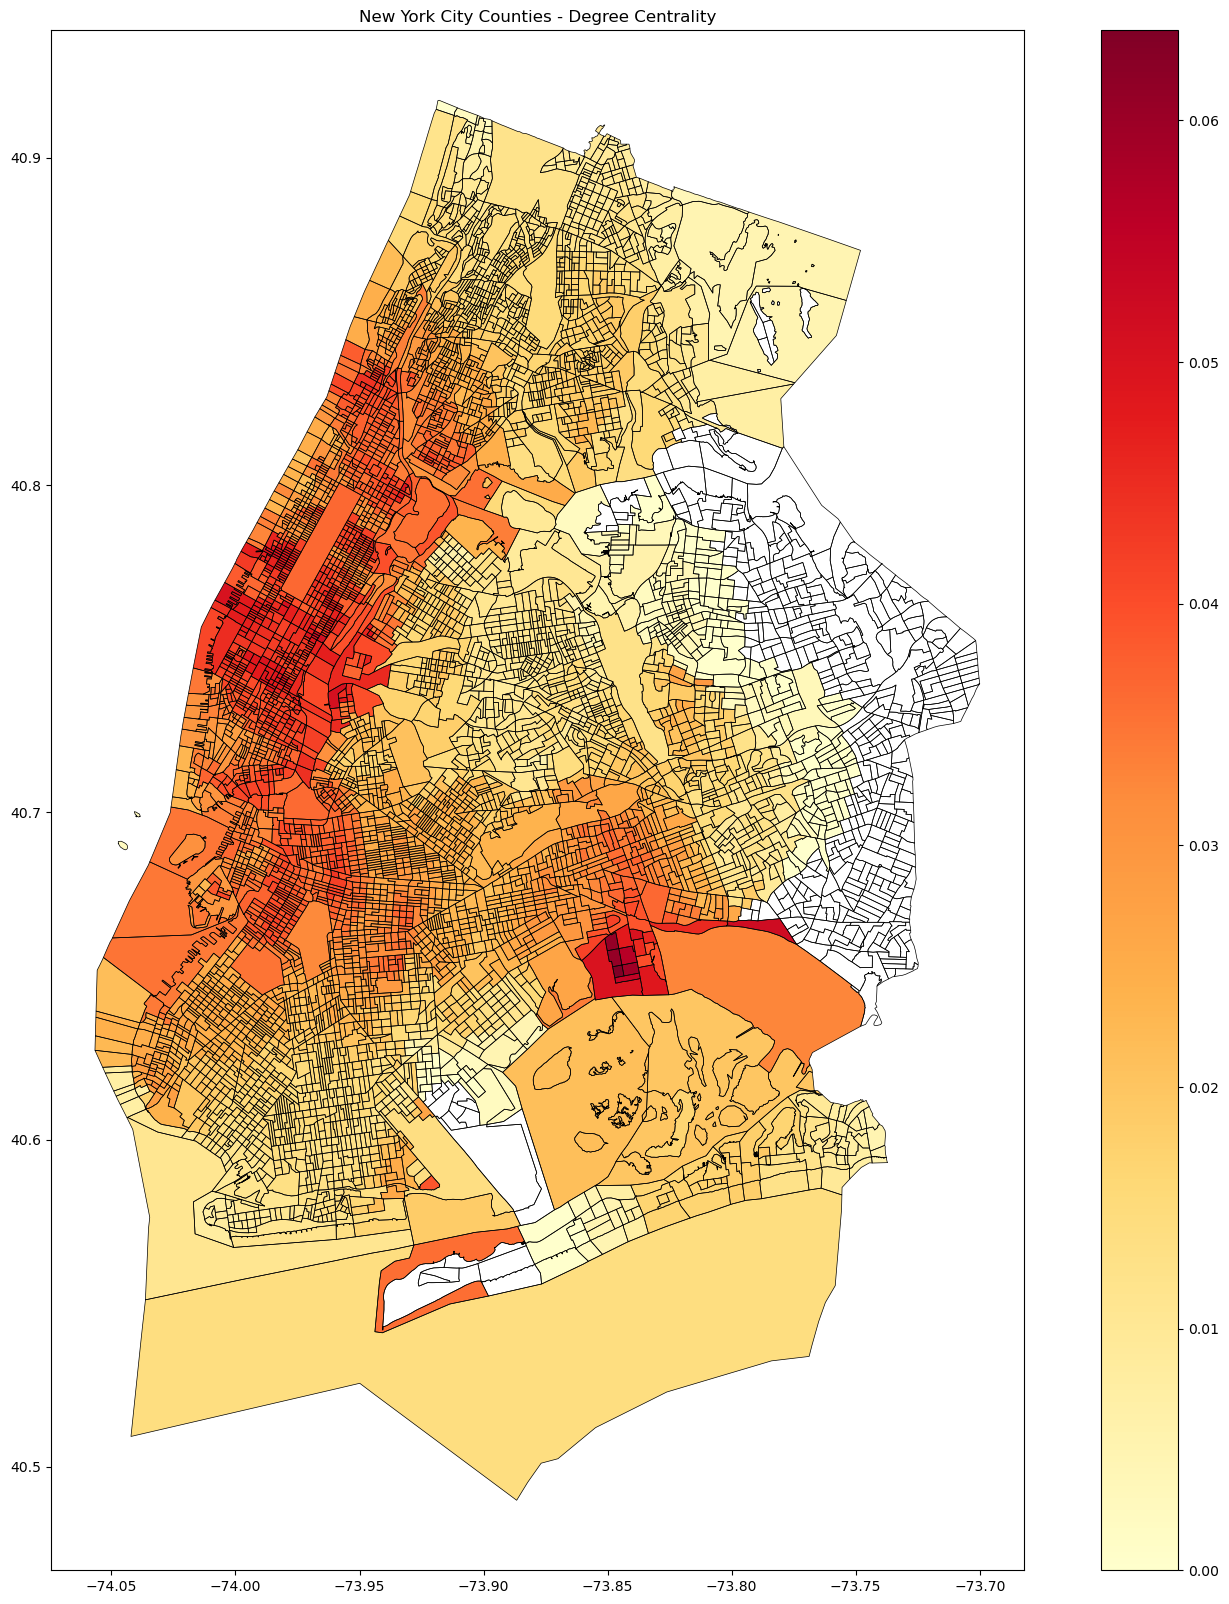

In [ ]:
# Spatially join the two GeoDataFrames and aggregate the values of the 'column_to_summarize_1' and 'column_to_summarize_2' columns
joined_gdf = gpd.sjoin(nyc_gdf, networkx_gdf_buffered, how='inner', op='intersects').groupby(['GEOID'])[['btwn']].mean().reset_index()

# Merge joined_gdf and networkx_gdf_buffered on GEOID
joined_df = pd.merge(joined_gdf, nyc_gdf, on='GEOID')
joined_gdf = gpd.GeoDataFrame(joined_df, geometry='geometry')

# Create a choropleth map of New York City counties based on the degree centrality
fig, ax = plt.subplots(figsize=(20, 20))
# joined_gdf.plot(column='dgrs', cmap='YlOrRd', legend=True, ax=ax)
joined_gdf.plot(column='btwn', cmap='YlOrRd', legend=True, ax=ax)

# Add block group boundaries
nyc_gdf.plot(linewidth=0.5, edgecolor='black', facecolor='none', ax=ax)

# # Add circles for each point with the buffer radius as the circle's radius
# for point in networkx_gdf_buffered.itertuples():
#     ax.add_patch(Circle(xy=point.geometry.centroid.coords[0], radius=0.01, edgecolor='black', facecolor='none'))

ax.set_title('New York City Counties - Degree Centrality')
plt.show()